## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.preprocessing import quick_preprocess
from src.models.lgbm_baseline import LGBMBaseline, train_baseline_model
from src.utils import (
    plot_roc_curve, 
    plot_confusion_matrix, 
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load and Preprocess Data

In [3]:
# Load and preprocess data using quick_preprocess function
print("Loading and preprocessing data...\n")

X_train, X_val, y_train, y_val = quick_preprocess(
    train_transaction_path='../data/train_transaction.csv',
    train_identity_path='../data/train_identity.csv',
    test_size=0.2,
    normalize=False  # LightGBM doesn't require normalization
)

print("\n✓ Data ready for training!")

Loading and preprocessing data...

Loading datasets...
  Train transaction: (590540, 394)
  Train identity: (144233, 41)
  Train transaction: (590540, 394)
  Train identity: (144233, 41)
  Merged train: (590540, 434)
✓ Data loaded successfully

PREPROCESSING PIPELINE

[1/5] Creating time-based features...
  Merged train: (590540, 434)
✓ Data loaded successfully

PREPROCESSING PIPELINE

[1/5] Creating time-based features...
✓ Time features created

[2/5] Identifying feature types...
✓ Time features created

[2/5] Identifying feature types...
Identified 410 numeric features
Identified 40 categorical features

[3/5] Handling missing values...
Handling missing values...
  Numeric strategy: median
  Categorical strategy: missing
Identified 410 numeric features
Identified 40 categorical features

[3/5] Handling missing values...
Handling missing values...
  Numeric strategy: median
  Categorical strategy: missing
✓ Missing values handled. Remaining nulls: 0

[4/5] Encoding categorical variab

In [4]:
# Display dataset information
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\nTraining set:")
print(f"  Samples: {X_train.shape[0]:,}")
print(f"  Features: {X_train.shape[1]:,}")
print(f"  Fraud rate: {y_train.mean()*100:.2f}%")
print(f"  Frauds: {y_train.sum():,}")
print(f"  Legitimate: {(1-y_train).sum():,}")

print(f"\nValidation set:")
print(f"  Samples: {X_val.shape[0]:,}")
print(f"  Features: {X_val.shape[1]:,}")
print(f"  Fraud rate: {y_val.mean()*100:.2f}%")
print(f"  Frauds: {y_val.sum():,}")
print(f"  Legitimate: {(1-y_val).sum():,}")

print(f"\nFeature names (first 20):")
print(X_train.columns[:20].tolist())
print("="*60)

DATASET SUMMARY

Training set:
  Samples: 472,432
  Features: 441
  Fraud rate: 3.51%
  Frauds: 16,599
  Legitimate: 455,833

Validation set:
  Samples: 118,108
  Features: 441
  Fraud rate: 3.44%
  Frauds: 4,064
  Legitimate: 114,044

Feature names (first 20):
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5']


## 3. Train Baseline Model

In [5]:
# Train baseline LightGBM model
model, metrics = train_baseline_model(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=1000,
    early_stopping_rounds=100
)

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 441

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.901322	valid's auc: 0.87093
[50]	train's auc: 0.901322	valid's auc: 0.87093
[100]	train's auc: 0.924048	valid's auc: 0.887771
[100]	train's auc: 0.924048	valid's auc: 0.887771
[150]	train's auc: 0.936745	valid's auc: 0.897026
[150]	train's auc: 0.936745	valid's auc: 0.897026
[200]	train's auc: 0.943915	valid's auc: 0.900288
[200]	train's auc: 0.943915	valid's auc: 0.900288
[250]	train's auc: 0.950411	valid's auc: 0.903249
[250]	train's auc: 0.950411	valid's auc: 0.903249
[300]	train's auc: 0.954704	valid's auc: 0.904535
[300]	train's auc: 0.954704	valid's auc: 0.904535
[350]	train's auc: 0.959842	valid's auc: 0.907374
[350]	train's auc: 0.959842	valid's auc: 0.907374
[4

In [6]:
# Display training metrics
print("="*60)
print("BASELINE MODEL METRICS")
print("="*60)
print(f"\nTraining AUC:     {metrics['train_auc']:.6f}")
print(f"Validation AUC:   {metrics['val_auc']:.6f}")
print(f"Best iteration:   {metrics['best_iteration']}")
print(f"Number of features: {metrics['num_features']}")
print(f"\nOverfitting gap:  {(metrics['train_auc'] - metrics['val_auc']):.6f}")
print("="*60)

BASELINE MODEL METRICS

Training AUC:     0.985921
Validation AUC:   0.915930
Best iteration:   1000
Number of features: 441

Overfitting gap:  0.069990


## 4. Make Predictions

In [7]:
# Generate predictions
train_pred_proba = model.predict(X_train)
val_pred_proba = model.predict(X_val)

print("✓ Predictions generated")
print(f"\nPrediction statistics (validation set):")
print(f"  Min:  {val_pred_proba.min():.6f}")
print(f"  Max:  {val_pred_proba.max():.6f}")
print(f"  Mean: {val_pred_proba.mean():.6f}")
print(f"  Median: {np.median(val_pred_proba):.6f}")

✓ Predictions generated

Prediction statistics (validation set):
  Min:  0.000018
  Max:  0.999855
  Mean: 0.033787
  Median: 0.006078


## 5. Model Evaluation

In [8]:
# Evaluate on validation set
val_metrics = evaluate_model(y_val, val_pred_proba, threshold=0.5)
print_evaluation_metrics(val_metrics)

MODEL EVALUATION METRICS

ROC-AUC Score:     0.915930
Accuracy:          0.9755
Precision:         0.7894
Recall:            0.3939
F1-Score:          0.5256

Confusion Matrix:
  True Positives:  1,601
  False Positives: 427
  True Negatives:  113,617
  False Negatives: 2,463


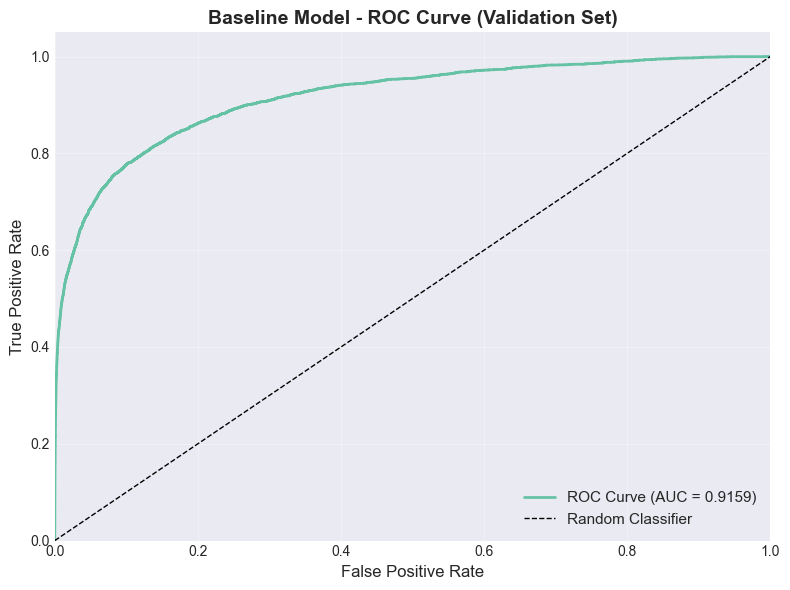

In [9]:
# Plot ROC curve
plot_roc_curve(y_val, val_pred_proba, title="Baseline Model - ROC Curve (Validation Set)")

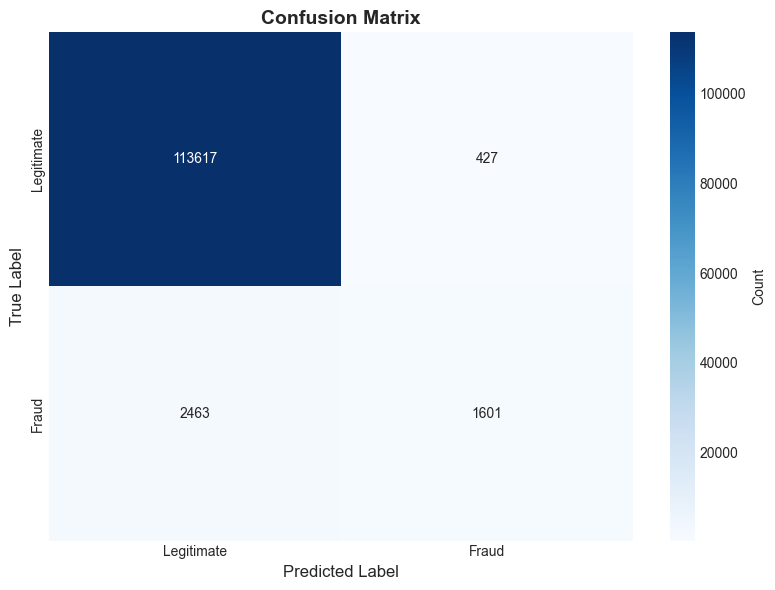

In [10]:
# Plot confusion matrix
val_pred_binary = (val_pred_proba >= 0.5).astype(int)
plot_confusion_matrix(y_val, val_pred_binary, normalize=False)

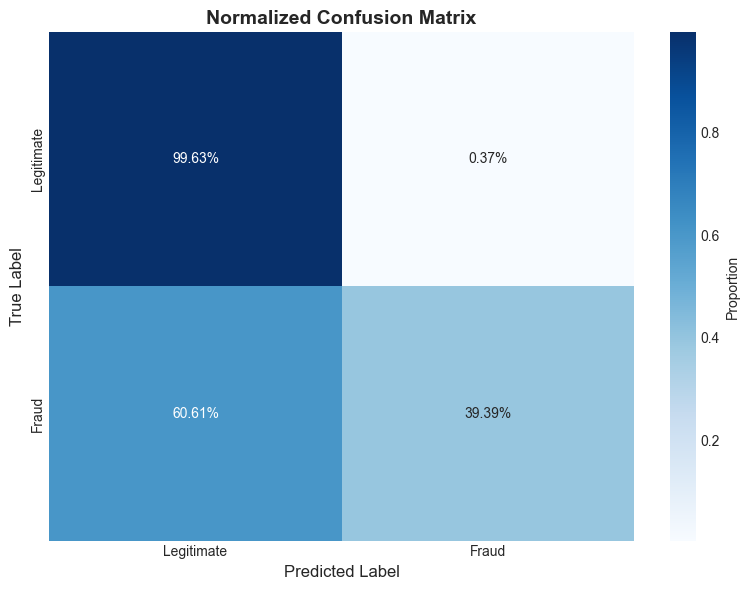

In [11]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_val, val_pred_binary, normalize=True)

## 6. Feature Importance Analysis

In [12]:
# Get top features
importance_df = model.get_feature_importance(top_n=30)

print("="*60)
print("TOP 30 MOST IMPORTANT FEATURES")
print("="*60)
print(importance_df.to_string(index=False))
print("="*60)

TOP 30 MOST IMPORTANT FEATURES
       feature   importance
          V258 85274.752754
            C1 44100.009333
           C14 40250.381477
           C13 30268.436084
         card1 27288.429255
         card2 23346.822083
TransactionAmt 22403.243393
         addr1 20177.333288
          V294 19672.520789
 TransactionDT 18141.813099
            C8 17912.833551
            D2 16980.660005
          V243 14718.745614
            C4 14194.176839
           D15 13665.560880
 P_emaildomain 12995.871898
         card6 12503.061611
          V308 10640.327499
 R_emaildomain 10580.455215
            D1 10195.282431
           C11  9662.536765
        DT_day  9454.483539
            C2  9061.329475
         card5  8879.676790
           D10  8828.059197
            C7  8527.877555
         dist1  8087.550695
          V283  7989.139767
            D4  7511.937762
            C6  7391.688093


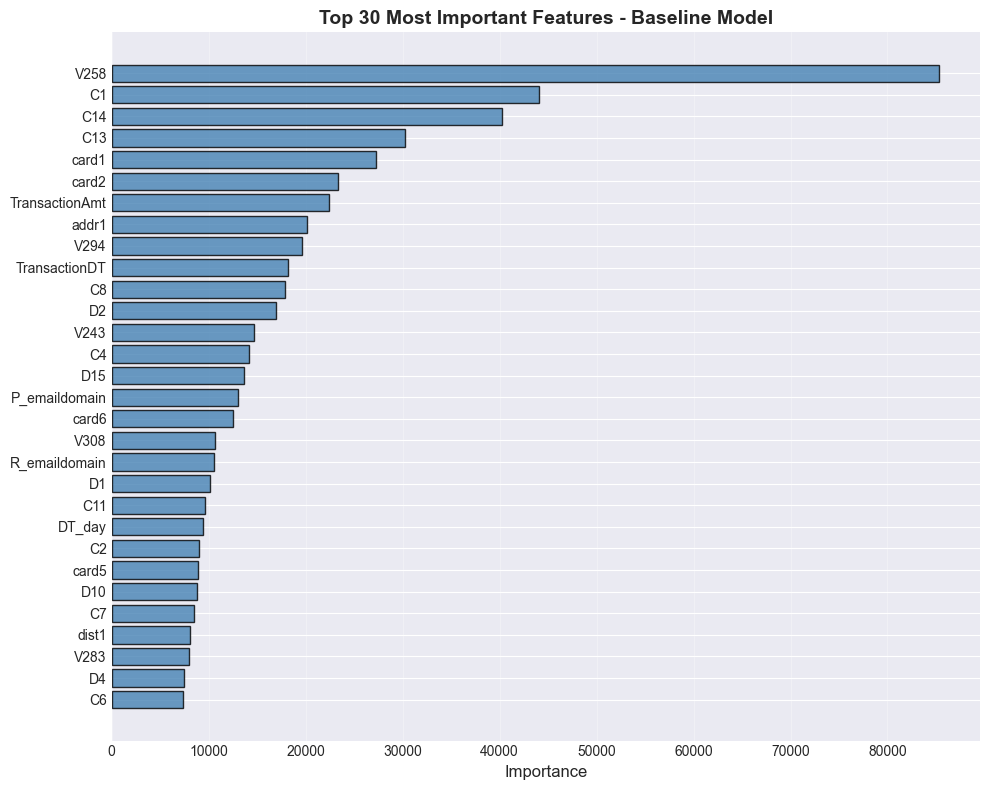

In [13]:
# Plot feature importance
plot_feature_importance(
    model.feature_importance, 
    top_n=30, 
    title="Top 30 Most Important Features - Baseline Model"
)

In [14]:
# Analyze feature importance by category
def categorize_feature(feature_name):
    """Categorize feature by its prefix."""
    if feature_name.startswith('V'):
        return 'V_features'
    elif feature_name.startswith('C'):
        return 'C_features'
    elif feature_name.startswith('D'):
        return 'D_features'
    elif feature_name.startswith('M'):
        return 'M_features'
    elif feature_name.startswith('card'):
        return 'card_features'
    elif feature_name.startswith('DT_'):
        return 'time_features'
    elif feature_name.startswith('id'):
        return 'id_features'
    elif 'email' in feature_name.lower():
        return 'email_features'
    elif 'device' in feature_name.lower():
        return 'device_features'
    else:
        return 'other_features'

# Categorize and aggregate importance
importance_full_df = model.get_feature_importance(top_n=None)
importance_full_df['category'] = importance_full_df['feature'].apply(categorize_feature)

category_importance = importance_full_df.groupby('category')['importance'].agg(['sum', 'mean', 'count'])
category_importance = category_importance.sort_values('sum', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*60)
print(category_importance.to_string())
print("="*60)


FEATURE IMPORTANCE BY CATEGORY
                          sum          mean  count
category                                          
V_features      339906.513759   1002.674082    339
C_features      202462.695859  14461.621133     14
D_features      111617.302635   4292.973178     26
card_features    80496.555029  13416.092505      6
other_features   77044.339395  11006.334199      7
id_features      51592.547693   1357.698623     38
email_features   23576.327113  11788.163556      2
M_features       19423.972425   2158.219158      9

FEATURE IMPORTANCE BY CATEGORY
                          sum          mean  count
category                                          
V_features      339906.513759   1002.674082    339
C_features      202462.695859  14461.621133     14
D_features      111617.302635   4292.973178     26
card_features    80496.555029  13416.092505      6
other_features   77044.339395  11006.334199      7
id_features      51592.547693   1357.698623     38
email_features   2

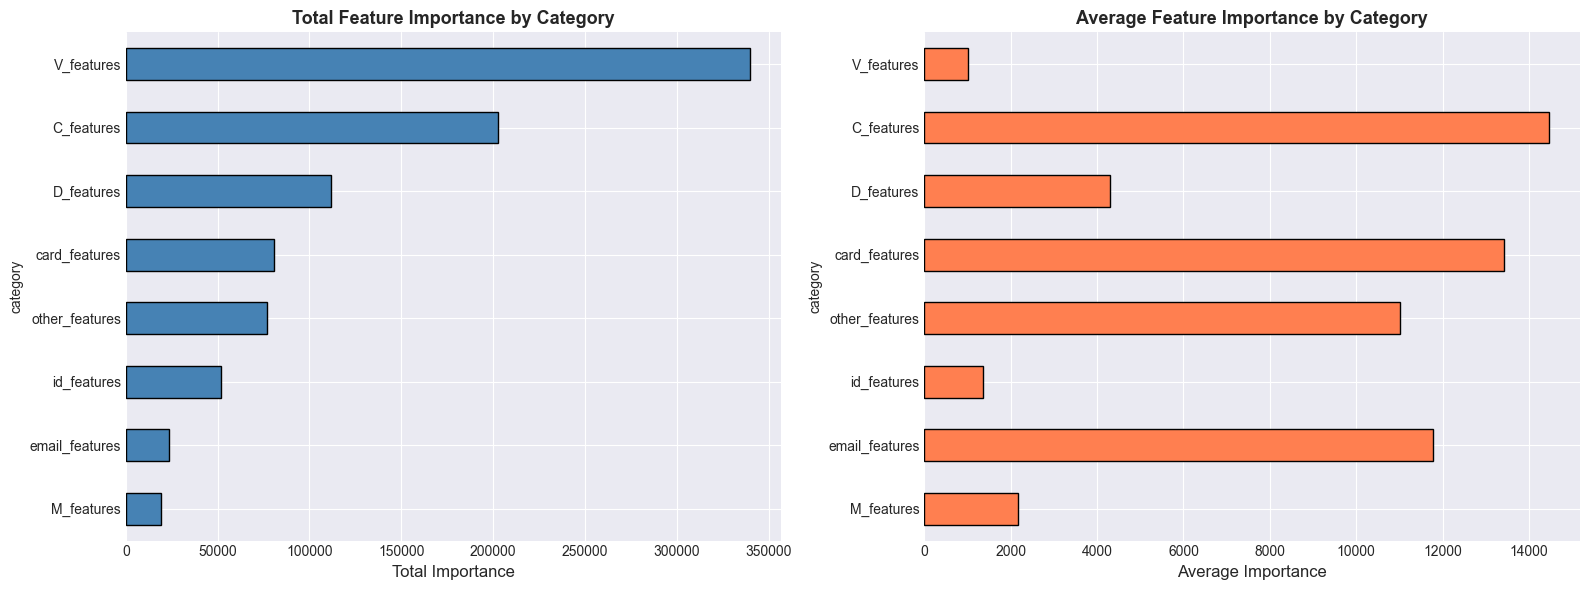

In [15]:
# Visualize category importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total importance by category
ax1 = axes[0]
category_importance['sum'].plot(kind='barh', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Total Importance', fontsize=12)
ax1.set_title('Total Feature Importance by Category', fontsize=13, fontweight='bold')
ax1.invert_yaxis()

# Average importance by category
ax2 = axes[1]
category_importance['mean'].plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Average Importance', fontsize=12)
ax2.set_title('Average Feature Importance by Category', fontsize=13, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Training History Visualization

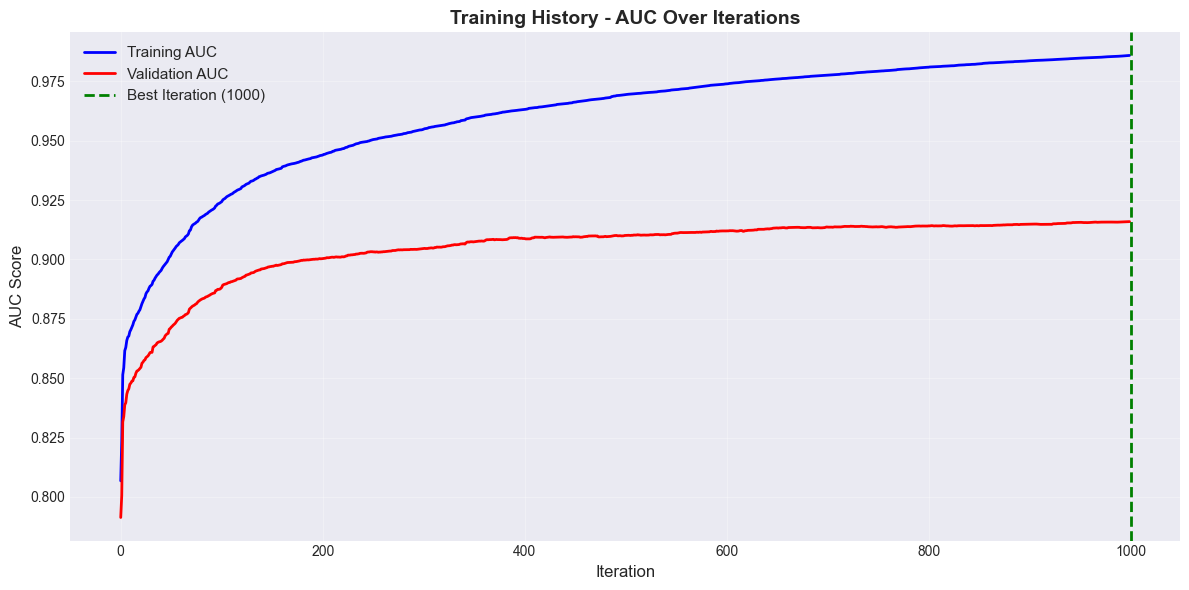

Best validation AUC achieved at iteration 1000


In [16]:
# Plot training history
history = model.training_history

fig, ax = plt.subplots(figsize=(12, 6))

iterations = range(len(history['train']['auc']))
ax.plot(iterations, history['train']['auc'], label='Training AUC', linewidth=2, color='blue')
ax.plot(iterations, history['valid']['auc'], label='Validation AUC', linewidth=2, color='red')
ax.axvline(x=model.model.best_iteration, color='green', linestyle='--', 
           linewidth=2, label=f'Best Iteration ({model.model.best_iteration})')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('Training History - AUC Over Iterations', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation AUC achieved at iteration {model.model.best_iteration}")

## 8. Prediction Distribution Analysis

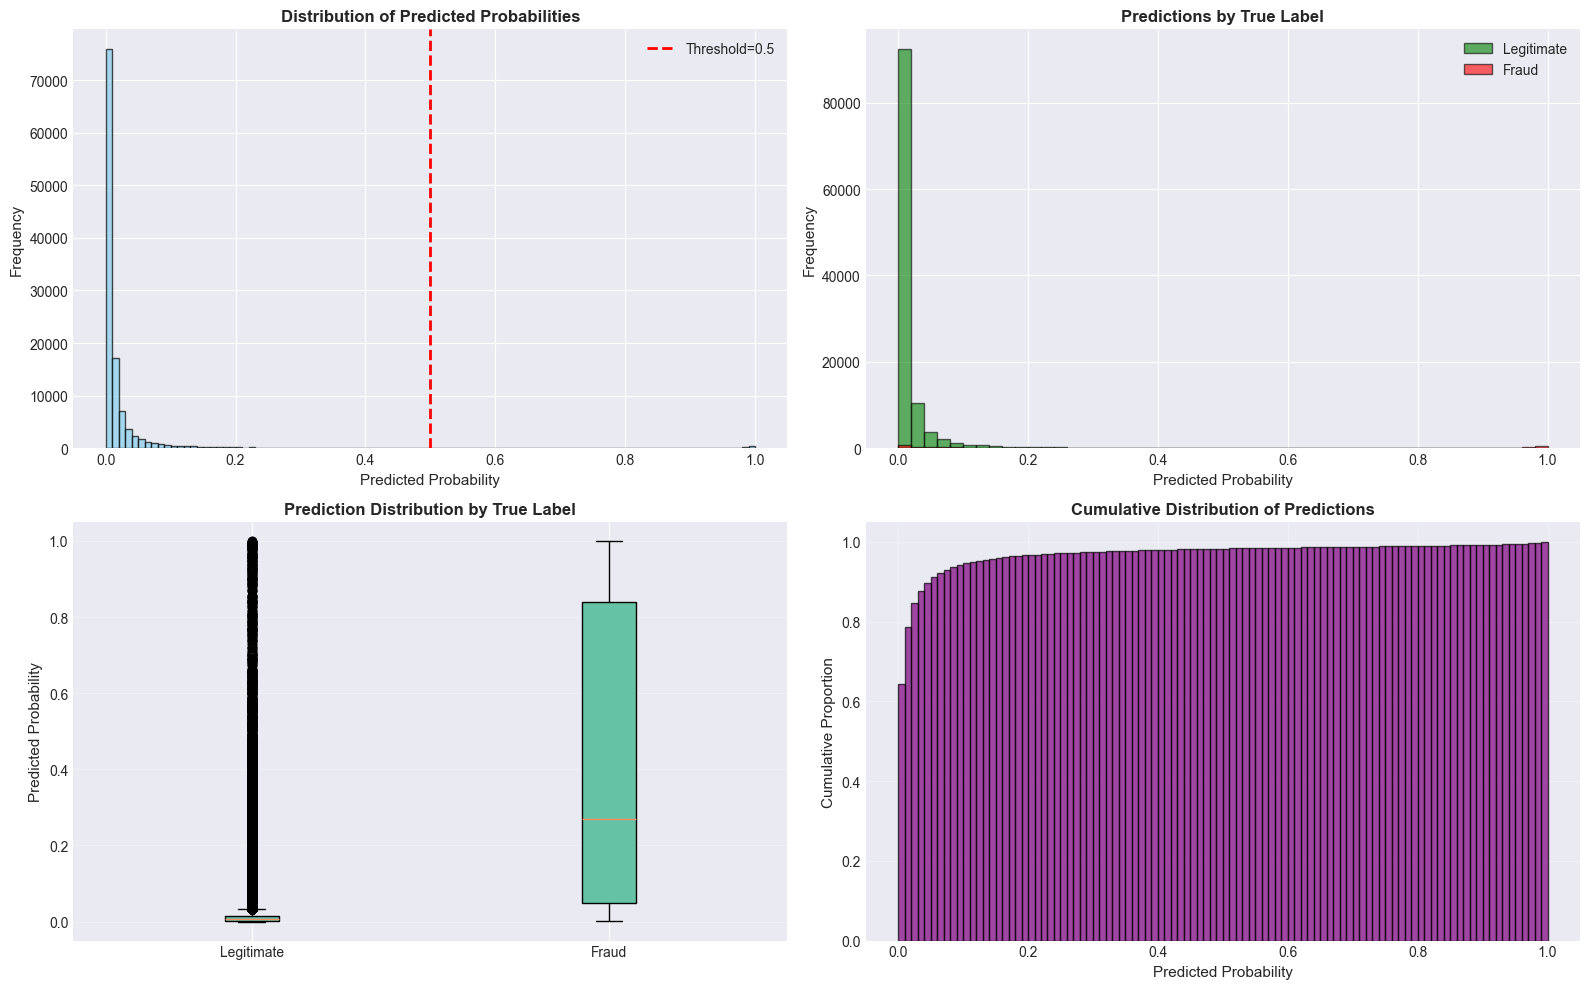


Prediction statistics by true label:

Legitimate transactions:
  Mean prediction: 0.020276
  Median prediction: 0.005775

Fraud transactions:
  Mean prediction: 0.412920
  Median prediction: 0.269610


In [17]:
# Analyze prediction distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Overall distribution
ax1 = axes[0, 0]
ax1.hist(val_pred_proba, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Predicted Probability', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
ax1.legend()

# By actual label
ax2 = axes[0, 1]
fraud_pred = val_pred_proba[y_val == 1]
legit_pred = val_pred_proba[y_val == 0]
ax2.hist(legit_pred, bins=50, alpha=0.6, label='Legitimate', color='green', edgecolor='black')
ax2.hist(fraud_pred, bins=50, alpha=0.6, label='Fraud', color='red', edgecolor='black')
ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Predictions by True Label', fontsize=12, fontweight='bold')
ax2.legend()

# Box plot by label
ax3 = axes[1, 0]
ax3.boxplot([legit_pred, fraud_pred], labels=['Legitimate', 'Fraud'], patch_artist=True)
ax3.set_ylabel('Predicted Probability', fontsize=11)
ax3.set_title('Prediction Distribution by True Label', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Cumulative distribution
ax4 = axes[1, 1]
ax4.hist(val_pred_proba, bins=100, cumulative=True, density=True, 
         color='purple', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Predicted Probability', fontsize=11)
ax4.set_ylabel('Cumulative Proportion', fontsize=11)
ax4.set_title('Cumulative Distribution of Predictions', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPrediction statistics by true label:")
print(f"\nLegitimate transactions:")
print(f"  Mean prediction: {legit_pred.mean():.6f}")
print(f"  Median prediction: {np.median(legit_pred):.6f}")
print(f"\nFraud transactions:")
print(f"  Mean prediction: {fraud_pred.mean():.6f}")
print(f"  Median prediction: {np.median(fraud_pred):.6f}")

## 9. Save Baseline Model

In [18]:
# Save model
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model
model.save_model('../models/lgbm_baseline.txt')

print("\n✓ Model saved successfully!")

✓ Model saved: ../models/lgbm_baseline.txt
✓ Metadata saved: ../models/lgbm_baseline_metadata.json

✓ Model saved successfully!


## 10. Key Findings and Next Steps

In [19]:
# Summary of baseline performance
print("="*60)
print("BASELINE MODEL SUMMARY")
print("="*60)

print("\n📊 MODEL PERFORMANCE:")
print(f"  • Validation ROC-AUC: {metrics['val_auc']:.6f}")
print(f"  • Training ROC-AUC: {metrics['train_auc']:.6f}")
print(f"  • Overfitting gap: {(metrics['train_auc'] - metrics['val_auc']):.6f}")
print(f"  • Best iteration: {metrics['best_iteration']}")

print("\n🎯 BASELINE ESTABLISHED:")
print(f"  • This is our score to beat: {metrics['val_auc']:.6f}")
print(f"  • Target (Top 10%): 0.945")
print(f"  • Gap to target: {0.945 - metrics['val_auc']:.6f}")

print("\n⭐ TOP FEATURE CATEGORIES:")
top_3_categories = category_importance.head(3)
for idx, (cat, row) in enumerate(top_3_categories.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['count']} features, total importance = {row['sum']:.0f}")

print("\n💡 KEY OBSERVATIONS:")
print("  1. Simple baseline achieves reasonable performance")
print("  2. Model shows some overfitting (can improve with regularization)")
print("  3. V features are most important (Vesta's engineered features)")
print("  4. Time features appear to be predictive")
print("  5. Clear separation in prediction distributions for fraud vs legitimate")

print("\n✅ NEXT STEPS TO IMPROVE:")
print("  • Reproduce top public kernel (target: 0.92 AUC)")
print("  • Add aggregation features (groupby card, email, device)")
print("  • Create interaction features")
print("  • Add advanced temporal features (velocity, recency)")
print("  • Hyperparameter tuning with Optuna")
print("  • Ensemble with XGBoost and CatBoost")

print("\n" + "="*60)
print("✓ BASELINE MODEL COMPLETE")
print("="*60)
print("\nReady to move to next phase: Reproduce Top Public Kernel")

BASELINE MODEL SUMMARY

📊 MODEL PERFORMANCE:
  • Validation ROC-AUC: 0.915930
  • Training ROC-AUC: 0.985921
  • Overfitting gap: 0.069990
  • Best iteration: 1000

🎯 BASELINE ESTABLISHED:
  • This is our score to beat: 0.915930
  • Target (Top 10%): 0.945
  • Gap to target: 0.029070

⭐ TOP FEATURE CATEGORIES:
  1. V_features: 339.0 features, total importance = 339907
  2. C_features: 14.0 features, total importance = 202463
  3. D_features: 26.0 features, total importance = 111617

💡 KEY OBSERVATIONS:
  1. Simple baseline achieves reasonable performance
  2. Model shows some overfitting (can improve with regularization)
  3. V features are most important (Vesta's engineered features)
  4. Time features appear to be predictive
  5. Clear separation in prediction distributions for fraud vs legitimate

✅ NEXT STEPS TO IMPROVE:
  • Reproduce top public kernel (target: 0.92 AUC)
  • Add aggregation features (groupby card, email, device)
  • Create interaction features
  • Add advanced temp